In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')
# Import Required Libraries
import os
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Install the 'ta' library if it's not already installed
!pip install ta

# Install the 'python-binance' library if it's not already installed
!pip install python-binance # This line is added to install the missing library

# Now import from 'ta'
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.trend import EMAIndicator
from binance.client import Client # This import should now work
from datetime import datetime, timedelta, timezone
import time
import os
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.trend import EMAIndicator
from binance.client import Client
from datetime import datetime, timedelta, timezone
import time
# Import Required Libraries
import os
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.trend import EMAIndicator
from binance.client import Client
from datetime import datetime, timedelta, timezone
import time

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


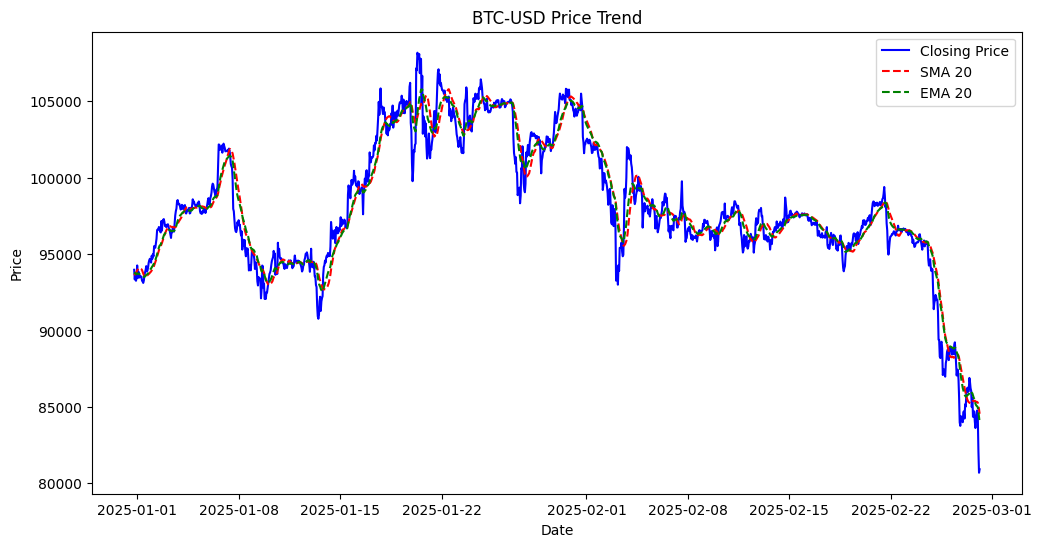

BTC-USD Model Accuracy: 0.84


[*********************100%***********************]  1 of 1 completed


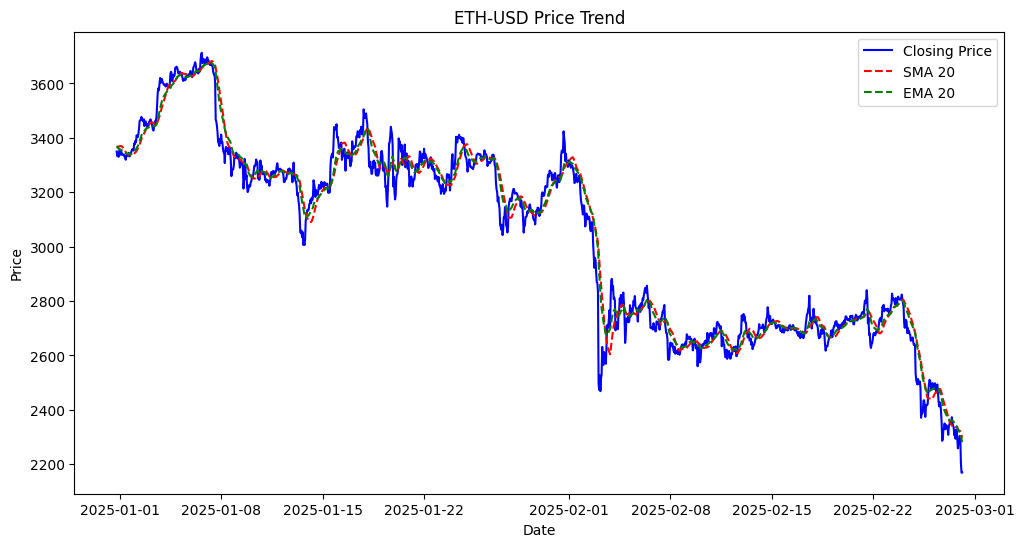

ETH-USD Model Accuracy: 0.83


[*********************100%***********************]  1 of 1 completed


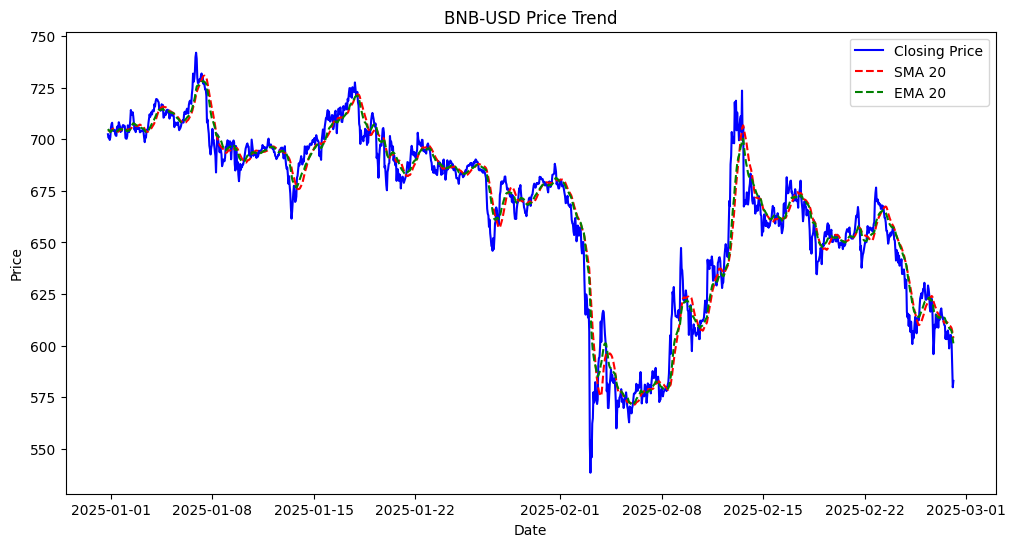

BNB-USD Model Accuracy: 0.84


[*********************100%***********************]  1 of 1 completed


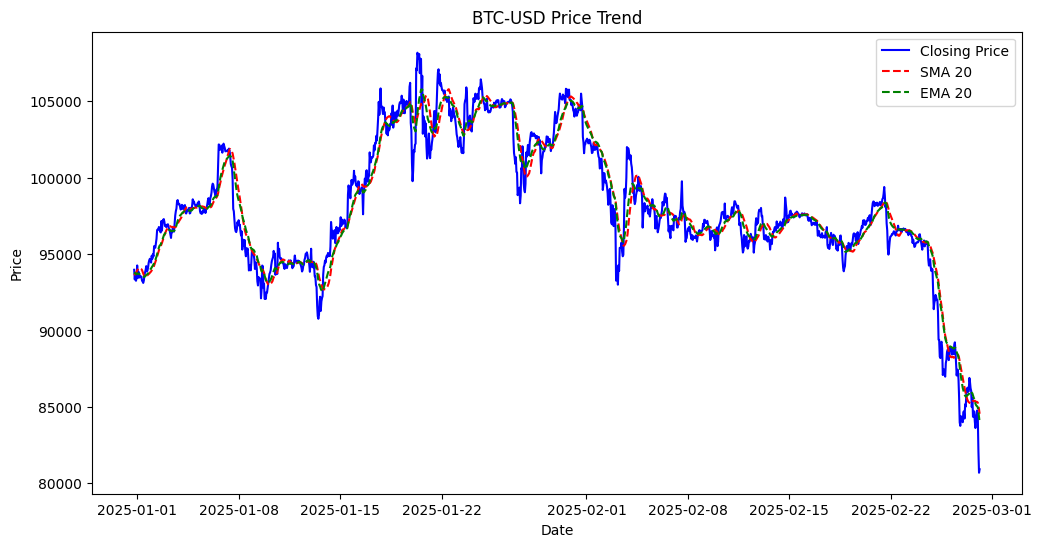

Probability of Increase for BTC-USD: 91.57%
BUY SIGNAL: Executing trade for BTC-USD


[*********************100%***********************]  1 of 1 completed


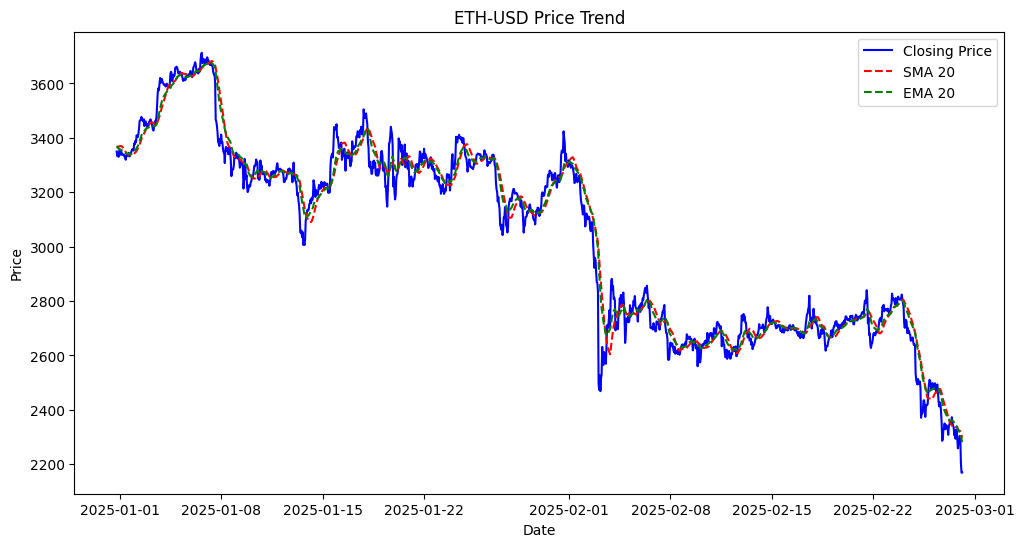

Probability of Increase for ETH-USD: 97.57%
BUY SIGNAL: Executing trade for ETH-USD


[*********************100%***********************]  1 of 1 completed


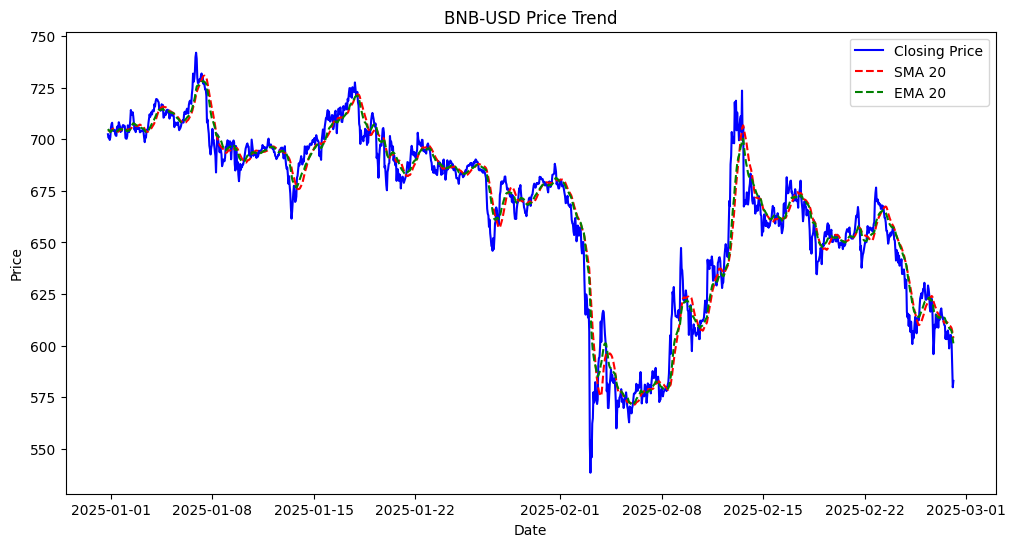

Probability of Increase for BNB-USD: 95.44%
BUY SIGNAL: Executing trade for BNB-USD


In [ ]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yfinance as yf
import time

def fetch_crypto_data(symbol, interval, lookback):
    """Fetch historical crypto data from Yahoo Finance"""
    df = yf.download(symbol, period="60d", interval=interval)  # Adjusted period to a valid format
    df.reset_index(inplace=True)
    df = df.rename(columns={'Datetime': 'timestamp', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    df.set_index("timestamp", inplace=True)
    return df

def add_technical_indicators(df):
    """Add technical indicators to dataset"""
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['RSI'] = compute_rsi(df['close'])
    df['ATR'] = compute_atr(df)
    df.dropna(inplace=True)
    return df

def compute_rsi(series, period=14):
    """Compute Relative Strength Index"""
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_atr(df, period=14):
    """Compute Average True Range"""
    df['H-L'] = df['high'] - df['low']
    df['H-C'] = abs(df['high'] - df['close'].shift(1))
    df['L-C'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    return df['TR'].rolling(window=period).mean()

def plot_price_trend(symbol, df):
    """Plot closing price and technical indicators"""
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['close'], label='Closing Price', color='blue')
    plt.plot(df.index, df['SMA_20'], label='SMA 20', linestyle='dashed', color='red')
    plt.plot(df.index, df['EMA_20'], label='EMA 20', linestyle='dashed', color='green')
    plt.title(f'{symbol} Price Trend')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def train_model(symbol):
    """Train an XGBoost model for the given crypto symbol"""
    df = fetch_crypto_data(symbol, "1h", 500)
    df = add_technical_indicators(df)
    plot_price_trend(symbol, df)

    df['future_return'] = df['close'].shift(-80) / df['close'] - 1
    df['label'] = (df['future_return'] > 0).astype(int)
    df.dropna(inplace=True)

    X = df.drop(['future_return', 'label', 'close'], axis=1)  # Ensure 'close' column is not in training data
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5)
    model.fit(X_train, y_train)
    joblib.dump(model, f"{symbol}_xgboost_model.pkl")

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{symbol} Model Accuracy: {accuracy:.2f}")

def predict(symbol, model_path):
    """Load trained model and predict probability"""
    model = joblib.load(model_path)
    df = fetch_crypto_data(symbol, "1h", 100)
    df = add_technical_indicators(df)
    plot_price_trend(symbol, df)
    X = df.iloc[-1:].drop(columns=['close'], errors='ignore')  # Ensure 'close' exists before dropping
    prob = model.predict_proba(X)[0][1] * 100
    print(f"Probability of Increase for {symbol}: {prob:.2f}%")
    return prob

def execute_trades():
    """Execute trades based on model predictions in real-time"""
    symbols = ["BTC-USD", "ETH-USD", "BNB-USD"]
    while True:
        for symbol in symbols:
            prob = predict(symbol, f"{symbol}_xgboost_model.pkl")
            if prob > 60:
                print(f"BUY SIGNAL: Executing trade for {symbol}")
                # Placeholder for trade execution logic
        time.sleep(3600)  # Wait for an hour before fetching new data

def main():
    symbols = ["BTC-USD", "ETH-USD", "BNB-USD"]
    for symbol in symbols:
        train_model(symbol)
    execute_trades()

if __name__ == "__main__":
    main()


# USING BINANCE API